In [ ]:
!pip install mne
!pip install tensorflow==2.14.0
!pip install tensorflow_privacy==0.9.0

In [ ]:
!pip install --upgrade numpy==1.26.4
!pip install --upgrade scikit-learn

In [ ]:
from google.colab import files
files.upload()

Saving EEGModels.py to EEGModels (1).py


{'EEGModels (1).py': b'"""\r\n ARL_EEGModels - A collection of Convolutional Neural Network models for EEG\r\n Signal Processing and Classification, using Keras and Tensorflow\r\n\r\n Requirements:\r\n    (1) tensorflow == 2.X (as of this writing, 2.0 - 2.3 have been verified\r\n        as working)\r\n \r\n To run the EEG/MEG ERP classification sample script, you will also need\r\n\r\n    (4) mne >= 0.17.1\r\n    (5) PyRiemann >= 0.2.5\r\n    (6) scikit-learn >= 0.20.1\r\n    (7) matplotlib >= 2.2.3\r\n    \r\n To use:\r\n    \r\n    (1) Place this file in the PYTHONPATH variable in your IDE (i.e.: Spyder)\r\n    (2) Import the model as\r\n        \r\n        from EEGModels import EEGNet    \r\n        \r\n        model = EEGNet(nb_classes = ..., Chans = ..., Samples = ...)\r\n        \r\n    (3) Then compile and fit the model\r\n    \r\n        model.compile(loss = ..., optimizer = ..., metrics = ...)\r\n        fitted    = model.fit(...)\r\n        predicted = model.predict(...)\r\n\

In [ ]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from EEGModels import EEGNet
from EEGModels import DeepConvNet
from EEGModels import ShallowConvNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
# from pyriemann.estimation import XdawnCovariances
# from pyriemann.tangentspace import TangentSpace
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib
import h5py

In [ ]:
# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################
data_path = str(sample.data_path())

# Set parameters and read data
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

In [ ]:
# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
labels = epochs.events[:, -1]

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

kernels, chans, samples = 1, 60, 151

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB



In [ ]:
import time
start = time.time()

In [ ]:
# take 50/25/25 percent of the data to train/validate/test
X_train      = X[0:144,]
Y_train      = y[0:144]
X_validate   = X[144:208,]
Y_validate   = y[144:208]
X_test       = X[208:,]
Y_test       = y[208:]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train-1)
Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)

# convert data to NHWC (trials, channels, samples, kernels) format. Data
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (144, 60, 151, 1)
144 train samples
80 test samples


In [ ]:
import os
os.makedirs('./tmp', exist_ok=True)

In [ ]:
model = DeepConvNet(nb_classes = 4, Chans = chans, Samples = samples, dropoutRate = 0.5)

l2_norm_clip = 1.5
noise_multiplier = 0.5 # was 1.3
batch_size = 16
num_microbatches = 1
learning_rate = 0.25
batch_size = 16

optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=1.0,      # Gradient clipping norm
    noise_multiplier=0.5,  # Controls privacy strength (lower = more privacy)
    num_microbatches=num_microbatches, # Use per-example gradients
    learning_rate=0.001
)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)



# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics = ['accuracy'])
print(model.summary())

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='./tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during
# optimization to balance it out. This data is approximately balanced so we
# don't need to do this, but is shown here for illustration/completeness.
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN +
# Riemannian geometry classification (below)
################################################################################
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300,
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 151, 1)]      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 147, 25)       150       
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 147, 25)        37525     
                                                                 
 batch_normalization_4 (Bat  (None, 1, 147, 25)        100       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 1, 147, 25)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 73, 25)         0         
 g2D)                                                      

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 1.39287, saving model to ./tmp/checkpoint.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 - 2s - loss: 1.6426 - acc: 0.2778 - val_loss: 1.3929 - val_acc: 0.2500 - 2s/epoch - 12ms/sample
Epoch 2/300

Epoch 2: val_loss did not improve from 1.39287
144/144 - 1s - loss: 1.5996 - acc: 0.2083 - val_loss: 1.3967 - val_acc: 0.2500 - 695ms/epoch - 5ms/sample
Epoch 3/300

Epoch 3: val_loss did not improve from 1.39287
144/144 - 1s - loss: 1.5559 - acc: 0.2222 - val_loss: 1.3974 - val_acc: 0.2500 - 715ms/epoch - 5ms/sample
Epoch 4/300

Epoch 4: val_loss did not improve from 1.39287
144/144 - 1s - loss: 1.5500 - acc: 0.1944 - val_loss: 1.3957 - val_acc: 0.2500 - 685ms/epoch - 5ms/sample
Epoch 5/300

Epoch 5: val_loss did not improve from 1.39287
144/144 - 1s - loss: 1.4983 - acc: 0.2639 - val_loss: 1.3951 - val_acc: 0.2500 - 672ms/epoch - 5ms/sample
Epoch 6/300

Epoch 6: val_loss improved from 1.39287 to 1.39142, saving model to ./tmp/checkpoint.h5


144/144 - 1s - loss: 1.5357 - acc: 0.2431 - val_loss: 1.3914 - val_acc: 0.2344 - 746ms/epoch - 5ms/sample
Epoch 7/300

Epoch 7: val_loss improved from 1.39142 to 1.38931, saving model to ./tmp/checkpoint.h5


144/144 - 1s - loss: 1.4866 - acc: 0.2500 - val_loss: 1.3893 - val_acc: 0.2344 - 744ms/epoch - 5ms/sample
Epoch 8/300

Epoch 8: val_loss improved from 1.38931 to 1.38641, saving model to ./tmp/checkpoint.h5


144/144 - 1s - loss: 1.5483 - acc: 0.2639 - val_loss: 1.3864 - val_acc: 0.2500 - 729ms/epoch - 5ms/sample
Epoch 9/300

Epoch 9: val_loss did not improve from 1.38641
144/144 - 1s - loss: 1.5210 - acc: 0.2361 - val_loss: 1.3886 - val_acc: 0.2656 - 684ms/epoch - 5ms/sample
Epoch 10/300

Epoch 10: val_loss improved from 1.38641 to 1.38385, saving model to ./tmp/checkpoint.h5


144/144 - 1s - loss: 1.4852 - acc: 0.2639 - val_loss: 1.3838 - val_acc: 0.2500 - 1s/epoch - 8ms/sample
Epoch 11/300

Epoch 11: val_loss did not improve from 1.38385
144/144 - 1s - loss: 1.5490 - acc: 0.2639 - val_loss: 1.3893 - val_acc: 0.2344 - 1s/epoch - 8ms/sample
Epoch 12/300

Epoch 12: val_loss improved from 1.38385 to 1.38322, saving model to ./tmp/checkpoint.h5


144/144 - 1s - loss: 1.4687 - acc: 0.2500 - val_loss: 1.3832 - val_acc: 0.1406 - 1s/epoch - 8ms/sample
Epoch 13/300

Epoch 13: val_loss improved from 1.38322 to 1.37429, saving model to ./tmp/checkpoint.h5


144/144 - 1s - loss: 1.5184 - acc: 0.2847 - val_loss: 1.3743 - val_acc: 0.3281 - 730ms/epoch - 5ms/sample
Epoch 14/300

Epoch 14: val_loss did not improve from 1.37429
144/144 - 1s - loss: 1.5532 - acc: 0.2292 - val_loss: 1.3807 - val_acc: 0.2812 - 705ms/epoch - 5ms/sample
Epoch 15/300

Epoch 15: val_loss did not improve from 1.37429
144/144 - 1s - loss: 1.5097 - acc: 0.2569 - val_loss: 1.3886 - val_acc: 0.2656 - 675ms/epoch - 5ms/sample
Epoch 16/300

Epoch 16: val_loss did not improve from 1.37429
144/144 - 1s - loss: 1.4710 - acc: 0.2708 - val_loss: 1.3925 - val_acc: 0.2656 - 699ms/epoch - 5ms/sample
Epoch 17/300

Epoch 17: val_loss did not improve from 1.37429
144/144 - 1s - loss: 1.5435 - acc: 0.2500 - val_loss: 1.3860 - val_acc: 0.2031 - 699ms/epoch - 5ms/sample
Epoch 18/300

Epoch 18: val_loss did not improve from 1.37429
144/144 - 1s - loss: 1.5056 - acc: 0.2500 - val_loss: 1.3838 - val_acc: 0.2344 - 692ms/epoch - 5ms/sample
Epoch 19/300

Epoch 19: val_loss did not improve from 

144/144 - 1s - loss: 1.5042 - acc: 0.2431 - val_loss: 1.3707 - val_acc: 0.2812 - 729ms/epoch - 5ms/sample
Epoch 38/300

Epoch 38: val_loss improved from 1.37072 to 1.36549, saving model to ./tmp/checkpoint.h5


144/144 - 1s - loss: 1.4520 - acc: 0.2639 - val_loss: 1.3655 - val_acc: 0.3125 - 721ms/epoch - 5ms/sample
Epoch 39/300

Epoch 39: val_loss did not improve from 1.36549
144/144 - 1s - loss: 1.5828 - acc: 0.2361 - val_loss: 1.3691 - val_acc: 0.4062 - 688ms/epoch - 5ms/sample
Epoch 40/300

Epoch 40: val_loss did not improve from 1.36549
144/144 - 1s - loss: 1.5021 - acc: 0.2986 - val_loss: 1.3729 - val_acc: 0.3281 - 696ms/epoch - 5ms/sample
Epoch 41/300

Epoch 41: val_loss improved from 1.36549 to 1.36440, saving model to ./tmp/checkpoint.h5


144/144 - 1s - loss: 1.5073 - acc: 0.2569 - val_loss: 1.3644 - val_acc: 0.3281 - 742ms/epoch - 5ms/sample
Epoch 42/300

Epoch 42: val_loss did not improve from 1.36440
144/144 - 1s - loss: 1.5040 - acc: 0.2569 - val_loss: 1.3825 - val_acc: 0.2344 - 703ms/epoch - 5ms/sample
Epoch 43/300

Epoch 43: val_loss did not improve from 1.36440
144/144 - 1s - loss: 1.5188 - acc: 0.2639 - val_loss: 1.3805 - val_acc: 0.2500 - 704ms/epoch - 5ms/sample
Epoch 44/300

Epoch 44: val_loss did not improve from 1.36440
144/144 - 1s - loss: 1.4699 - acc: 0.2708 - val_loss: 1.3890 - val_acc: 0.2656 - 1s/epoch - 7ms/sample
Epoch 45/300

Epoch 45: val_loss did not improve from 1.36440
144/144 - 1s - loss: 1.5290 - acc: 0.2292 - val_loss: 1.3950 - val_acc: 0.2500 - 1s/epoch - 8ms/sample
Epoch 46/300

Epoch 46: val_loss did not improve from 1.36440
144/144 - 1s - loss: 1.5403 - acc: 0.2431 - val_loss: 1.3739 - val_acc: 0.3438 - 1s/epoch - 8ms/sample
Epoch 47/300

Epoch 47: val_loss did not improve from 1.36440
1

144/144 - 1s - loss: 1.4617 - acc: 0.2778 - val_loss: 1.3591 - val_acc: 0.3594 - 648ms/epoch - 5ms/sample
Epoch 97/300

Epoch 97: val_loss did not improve from 1.35913
144/144 - 1s - loss: 1.4651 - acc: 0.2847 - val_loss: 1.3698 - val_acc: 0.2969 - 621ms/epoch - 4ms/sample
Epoch 98/300

Epoch 98: val_loss did not improve from 1.35913
144/144 - 1s - loss: 1.4484 - acc: 0.2917 - val_loss: 1.3821 - val_acc: 0.2656 - 626ms/epoch - 4ms/sample
Epoch 99/300

Epoch 99: val_loss did not improve from 1.35913
144/144 - 1s - loss: 1.5571 - acc: 0.2778 - val_loss: 1.3744 - val_acc: 0.2656 - 625ms/epoch - 4ms/sample
Epoch 100/300

Epoch 100: val_loss did not improve from 1.35913
144/144 - 1s - loss: 1.4100 - acc: 0.2986 - val_loss: 1.3832 - val_acc: 0.3125 - 644ms/epoch - 4ms/sample
Epoch 101/300

Epoch 101: val_loss did not improve from 1.35913
144/144 - 1s - loss: 1.5454 - acc: 0.2569 - val_loss: 1.3867 - val_acc: 0.2344 - 656ms/epoch - 5ms/sample
Epoch 102/300

Epoch 102: val_loss did not improve

144/144 - 1s - loss: 1.4950 - acc: 0.2292 - val_loss: 1.3538 - val_acc: 0.3594 - 655ms/epoch - 5ms/sample
Epoch 266/300

Epoch 266: val_loss did not improve from 1.35384
144/144 - 1s - loss: 1.4964 - acc: 0.2917 - val_loss: 1.3649 - val_acc: 0.2812 - 616ms/epoch - 4ms/sample
Epoch 267/300

Epoch 267: val_loss did not improve from 1.35384
144/144 - 1s - loss: 1.3557 - acc: 0.3472 - val_loss: 1.3626 - val_acc: 0.2344 - 641ms/epoch - 4ms/sample
Epoch 268/300

Epoch 268: val_loss did not improve from 1.35384
144/144 - 1s - loss: 1.4687 - acc: 0.2569 - val_loss: 1.3623 - val_acc: 0.2031 - 609ms/epoch - 4ms/sample
Epoch 269/300

Epoch 269: val_loss did not improve from 1.35384
144/144 - 1s - loss: 1.4841 - acc: 0.2778 - val_loss: 1.3780 - val_acc: 0.2500 - 628ms/epoch - 4ms/sample
Epoch 270/300

Epoch 270: val_loss did not improve from 1.35384
144/144 - 1s - loss: 1.4728 - acc: 0.2639 - val_loss: 1.3748 - val_acc: 0.2500 - 619ms/epoch - 4ms/sample
Epoch 271/300

Epoch 271: val_loss did not i

144/144 - 1s - loss: 1.4672 - acc: 0.2847 - val_loss: 1.3512 - val_acc: 0.3125 - 646ms/epoch - 4ms/sample
Epoch 274/300

Epoch 274: val_loss improved from 1.35119 to 1.35057, saving model to ./tmp/checkpoint.h5


144/144 - 1s - loss: 1.4581 - acc: 0.2847 - val_loss: 1.3506 - val_acc: 0.3438 - 644ms/epoch - 4ms/sample
Epoch 275/300

Epoch 275: val_loss did not improve from 1.35057
144/144 - 1s - loss: 1.4284 - acc: 0.2778 - val_loss: 1.3606 - val_acc: 0.3438 - 963ms/epoch - 7ms/sample
Epoch 276/300

Epoch 276: val_loss improved from 1.35057 to 1.34321, saving model to ./tmp/checkpoint.h5


144/144 - 1s - loss: 1.4422 - acc: 0.2986 - val_loss: 1.3432 - val_acc: 0.3438 - 1s/epoch - 7ms/sample
Epoch 277/300

Epoch 277: val_loss did not improve from 1.34321
144/144 - 1s - loss: 1.4735 - acc: 0.2917 - val_loss: 1.3523 - val_acc: 0.3281 - 1s/epoch - 7ms/sample
Epoch 278/300

Epoch 278: val_loss improved from 1.34321 to 1.34298, saving model to ./tmp/checkpoint.h5


144/144 - 1s - loss: 1.4189 - acc: 0.3750 - val_loss: 1.3430 - val_acc: 0.3750 - 667ms/epoch - 5ms/sample
Epoch 279/300

Epoch 279: val_loss improved from 1.34298 to 1.33940, saving model to ./tmp/checkpoint.h5


144/144 - 1s - loss: 1.4650 - acc: 0.2917 - val_loss: 1.3394 - val_acc: 0.4062 - 654ms/epoch - 5ms/sample
Epoch 280/300

Epoch 280: val_loss did not improve from 1.33940
144/144 - 1s - loss: 1.3869 - acc: 0.3264 - val_loss: 1.3442 - val_acc: 0.4375 - 614ms/epoch - 4ms/sample
Epoch 281/300

Epoch 281: val_loss did not improve from 1.33940
144/144 - 1s - loss: 1.4976 - acc: 0.2917 - val_loss: 1.3461 - val_acc: 0.3281 - 615ms/epoch - 4ms/sample
Epoch 282/300

Epoch 282: val_loss did not improve from 1.33940
144/144 - 1s - loss: 1.4567 - acc: 0.2569 - val_loss: 1.3489 - val_acc: 0.3438 - 608ms/epoch - 4ms/sample
Epoch 283/300

Epoch 283: val_loss did not improve from 1.33940
144/144 - 1s - loss: 1.5042 - acc: 0.3333 - val_loss: 1.3530 - val_acc: 0.3438 - 602ms/epoch - 4ms/sample
Epoch 284/300

Epoch 284: val_loss did not improve from 1.33940
144/144 - 1s - loss: 1.5616 - acc: 0.2500 - val_loss: 1.3607 - val_acc: 0.2031 - 620ms/epoch - 4ms/sample
Epoch 285/300

Epoch 285: val_loss did not i

144/144 - 1s - loss: 1.4052 - acc: 0.3333 - val_loss: 1.3330 - val_acc: 0.3594 - 659ms/epoch - 5ms/sample
Epoch 288/300

Epoch 288: val_loss did not improve from 1.33297
144/144 - 1s - loss: 1.3919 - acc: 0.3056 - val_loss: 1.3458 - val_acc: 0.2500 - 606ms/epoch - 4ms/sample
Epoch 289/300

Epoch 289: val_loss did not improve from 1.33297
144/144 - 1s - loss: 1.5205 - acc: 0.3125 - val_loss: 1.3460 - val_acc: 0.2500 - 635ms/epoch - 4ms/sample
Epoch 290/300

Epoch 290: val_loss did not improve from 1.33297
144/144 - 1s - loss: 1.4901 - acc: 0.2778 - val_loss: 1.3549 - val_acc: 0.2812 - 631ms/epoch - 4ms/sample
Epoch 291/300

Epoch 291: val_loss did not improve from 1.33297
144/144 - 1s - loss: 1.4002 - acc: 0.3542 - val_loss: 1.3642 - val_acc: 0.2500 - 618ms/epoch - 4ms/sample
Epoch 292/300

Epoch 292: val_loss did not improve from 1.33297
144/144 - 1s - loss: 1.4311 - acc: 0.3056 - val_loss: 1.3638 - val_acc: 0.2188 - 632ms/epoch - 4ms/sample
Epoch 293/300

Epoch 293: val_loss did not i

In [ ]:
# load optimal weights
model.load_weights('./tmp/checkpoint.h5')

###############################################################################
# can alternatively used the weights provided in the repo. If so it should get
# you 93% accuracy. Change the WEIGHTS_PATH variable to wherever it is on your
# system.
###############################################################################

# WEIGHTS_PATH = /path/to/EEGNet-8-2-weights.h5
# model.load_weights(WEIGHTS_PATH)

###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))


############################# PyRiemann Portion ##############################

# code is taken from PyRiemann's ERP sample script, which is decoding in
# the tangent space with a logistic regression

# n_components = 2  # pick some components

# # set up sklearn pipeline
# clf = make_pipeline(XdawnCovariances(n_components),
#                     TangentSpace(metric='riemann'),
#                     LogisticRegression())

# preds_rg     = np.zeros(len(Y_test))

# # reshape back to (trials, channels, samples)
# X_train      = X_train.reshape(X_train.shape[0], chans, samples)
# X_test       = X_test.reshape(X_test.shape[0], chans, samples)

# # train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# # labels need to be back in single-column format
# clf.fit(X_train, Y_train.argmax(axis = -1))
# preds_rg     = clf.predict(X_test)

# # Printing the results
# acc2         = np.mean(preds_rg == Y_test.argmax(axis = -1))
# print("Classification accuracy: %f " % (acc2))

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Classification accuracy: 0.325000 


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
# plot the confusion matrices for both classifiers
names        = ['audio left', 'audio right', 'vis left', 'vis right']
# plt.figure(0)
confusion_matrix_1 = confusion_matrix(preds, Y_test.argmax(axis = -1))

# plt.figure(1)
# confusion_matrix_2 = confusion_matrix(preds_rg, Y_test.argmax(axis = -1))

In [ ]:
confusion_matrix_1

array([[ 2,  4,  0,  2],
       [13, 14, 10,  5],
       [ 4,  3,  8, 11],
       [ 0,  0,  2,  2]])

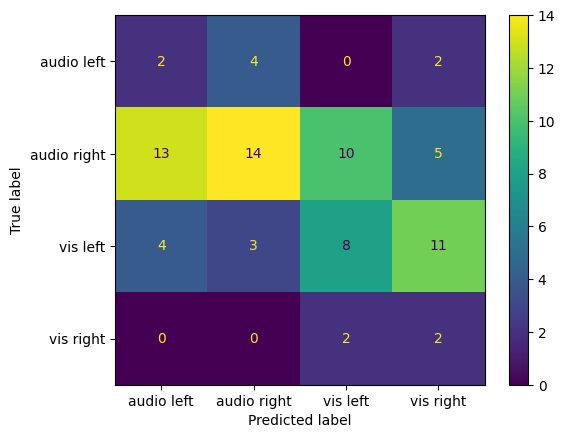

In [ ]:
disp1 = ConfusionMatrixDisplay(confusion_matrix_1, display_labels = names)
disp1.plot()

# ConfusionMatrixDisplay(confusion_matrix_2, display_labels = names)

In [ ]:
print(classification_report(preds, Y_test.argmax(axis = -1)))

              precision    recall  f1-score   support

           0       0.11      0.25      0.15         8
           1       0.67      0.33      0.44        42
           2       0.40      0.31      0.35        26
           3       0.10      0.50      0.17         4

    accuracy                           0.33        80
   macro avg       0.32      0.35      0.28        80
weighted avg       0.50      0.33      0.37        80



In [ ]:
#disp2 = ConfusionMatrixDisplay(confusion_matrix_2, display_labels = names)
#disp2.plot()

In [ ]:
end = time.time()
print(f"Took {end - start:.2f} seconds")

Took 225.00 seconds


In [58]:
eps, _ = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(n=X_train.shape[0],
                      batch_size=batch_size,
                      noise_multiplier=noise_multiplier,
                      epochs=300,
                      delta=1e-5)

print(eps)

334.8981894427235
